In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import cv2

import copy
from collections import namedtuple
import os
import random
import shutil
import time



In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
train_dir = 'mydataset/train'
test_dir = 'mydataset/train'

train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = transforms.ToTensor())
test_data = datasets.ImageFolder(root = test_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)


In [4]:
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

# train_transforms = transforms.Compose([
#                            transforms.Resize(pretrained_size),
#                            transforms.RandomRotation(5),
#                            transforms.RandomHorizontalFlip(0.5),
#                            transforms.RandomCrop(pretrained_size, padding = 10),
#                            transforms.ToTensor(),
#                            transforms.Normalize(mean = pretrained_means, 
#                                                 std = pretrained_stds)
#                        ])

# test_transforms = transforms.Compose([
#                            transforms.Resize(pretrained_size),
#                            transforms.CenterCrop(pretrained_size),
#                            transforms.ToTensor(),
#                            transforms.Normalize(mean = pretrained_means, 
#                                                 std = pretrained_stds)
#                        ])

# train_data = datasets.ImageFolder(root = train_dir, 
#                                   transform = train_transforms)

# test_data = datasets.ImageFolder(root = test_dir, 
#                                  transform = test_transforms)

VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                            [n_train_examples, n_valid_examples])

# train_data, valid_data = train_data[1001:], train_data[:1000]

valid_data = copy.deepcopy(valid_data)
# valid_data.dataset.transform = test_transforms



print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Calculated means: tensor([0.4397, 0.4908, 0.5373])
Calculated stds: tensor([0.1499, 0.1546, 0.1826])
Number of training examples: 6669
Number of validation examples: 741
Number of testing examples: 7410


In [5]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)


In [6]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    



In [7]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(n_images/6)
    cols = 6

    fig = plt.figure(figsize = (35, 170))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')
    plt.show()


In [19]:
N_IMAGES = 500

images, labels = zip(*[(image, label) for image, label in 
                           [test_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

# plot_images(images, labels, classes)

In [20]:
images, labels = zip(*[(image, label) for image, label in 
                           test_data])

classes = test_data.classes

if 1 in labels:
    print('ok')
else:
    print('argh')

ok


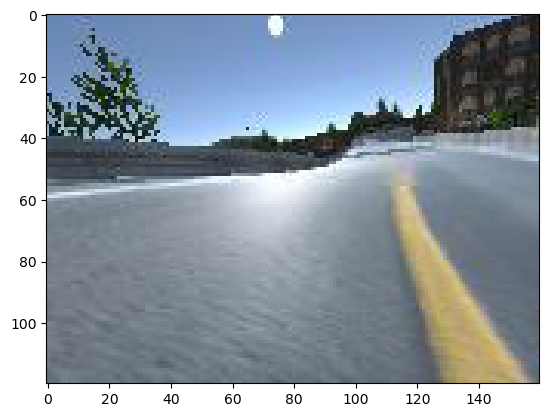

In [23]:
plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())

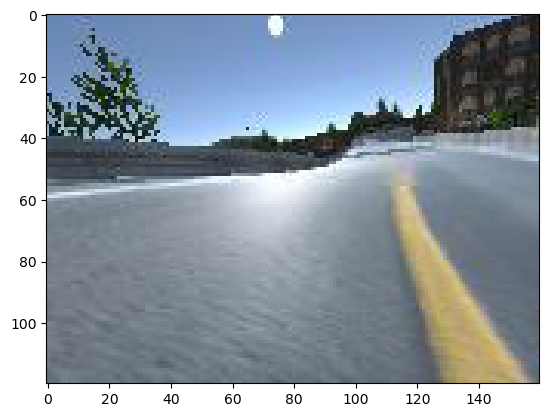

In [24]:
plt.imshow(test_data[0][0].permute(1, 2, 0).cpu().numpy())

In [30]:
test_iterator